# OCR CNH

Minha primeira ideia para resolver esse problema foi ultizar um processamento digital de imagem (PDI).


Pensei em utlizar o OpenCV para segmetar as regiões da CNH e com isso aplicar o Tesseract para identificar os textos presentes na imagem. Como o Tesseract não faz parte do Google Colab tenho que instala-lo.

In [ ]:
# Instalando o Tesseract
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Cada biblioteca utilizada neste codígo tem sua função descrita abaixo:


*   Numpy: para operações com as matrizes e arrays;

*   cv2: para PDI;

*   PIL: carrega a imagem para ser processada pelo Tesseract;

*   cv2_imshow: exibe a imagem na tela;

*   imutils: faz operações com a imagens, como por exemplo resize e conversão dos contonornos;

*   pytesseract: responsável pela execução do OCR;

In [ ]:
# Importando as libs
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import imutils
import pytesseract

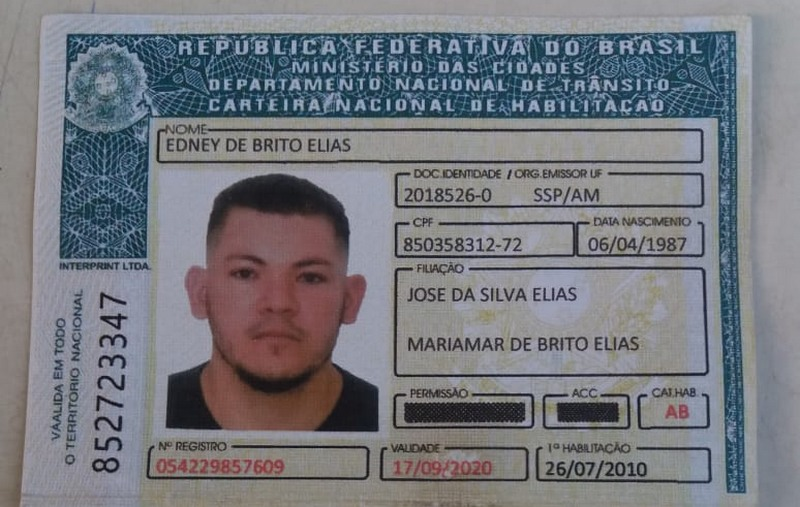

507, 800


In [ ]:
# Carregando a imagem
img = cv2.imread("/content/CNH-falsa-Manaus.jpeg")
cv2_imshow(img)
print(f"{img.shape[0]}, {img.shape[1]}")

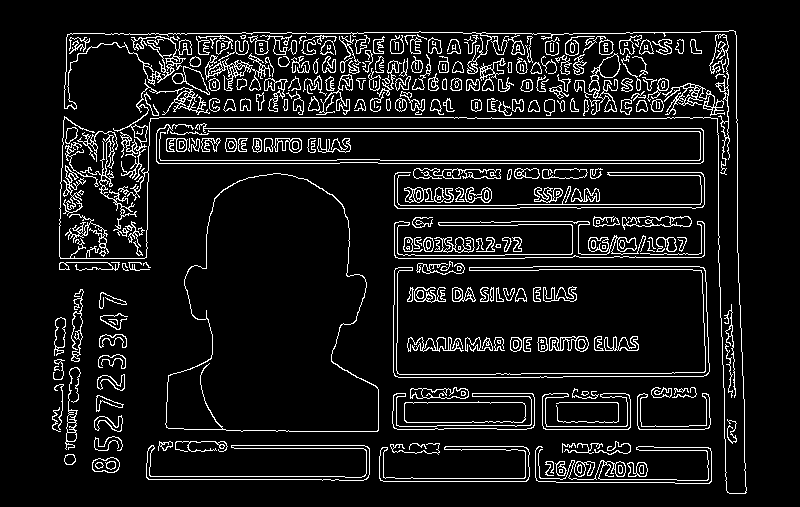

In [ ]:
# Transformando a imagem em grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Aplicando filtro Gausiano para retirar interferencias na imagem
img_blur = cv2.GaussianBlur(img, (5,5),0)
# Aplicando um detector de borda para ter uma melhor ideia de que tipo de features podem ser retiradas da imagem
img_canny = cv2.Canny(img_blur, 70, 220)
cv2_imshow(img_canny)

Na imagem resultante do canny é possível observar que o contorno da foto do portador da CNH fica em destaque. Pensei em utilizar isso como referência dentro da imagem. Sabendo que a CNH é um documento padrão em todo o Brasil, utilizar uma referência para extrair os outros dados (nome, CPF, e RG) pode ser uma boa estrategia. 

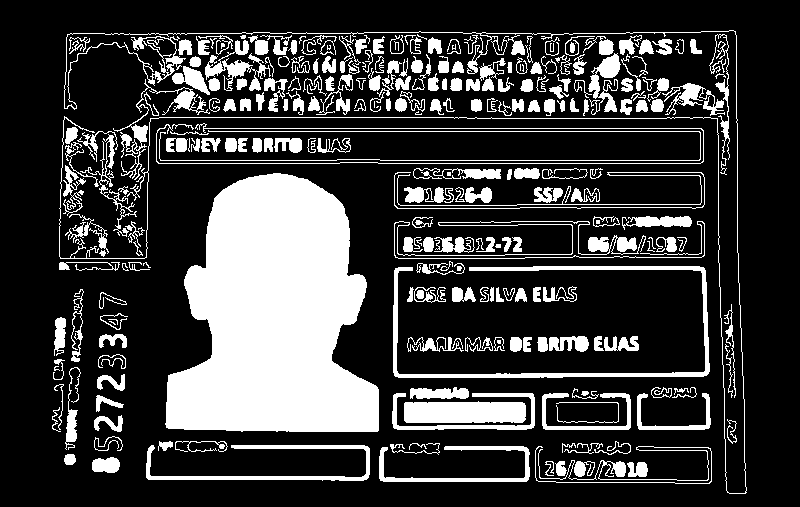

In [ ]:
'''
Utilizei um fitro chamado floodFill...este filtro preenche contornos...a estratégia é fazer com que o contorno da foto do portador da CNH 
se torne o contorno com maior densidade de pixels brancos
'''
h, w = img_canny.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
img_floodFill = img_canny.copy()
cv2.floodFill(img_floodFill, mask, (0,0), 255)
img_floodFill_inv = cv2.bitwise_not(img_floodFill)
img_processada = img_canny | img_floodFill_inv
cv2_imshow(img_processada)

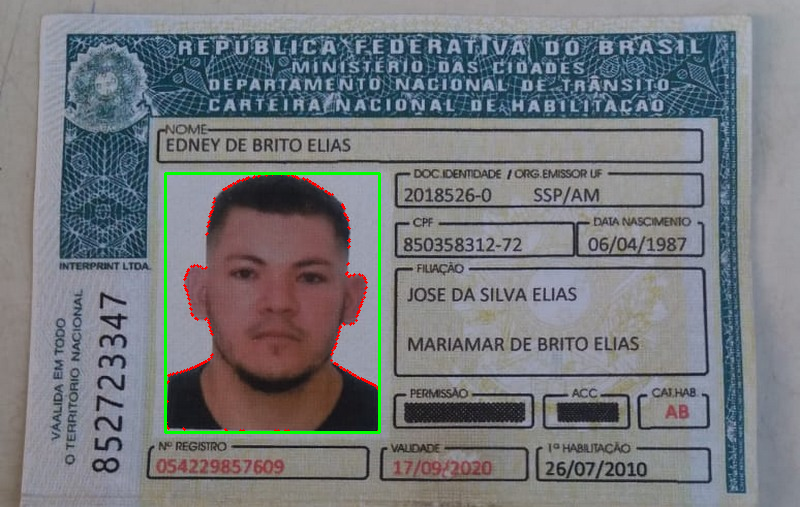

In [ ]:
# Encontrando o maior contorno, que deve ser o da foto do portador da CNH e desenhando um retângulo envolta desse contorno
contornos = cv2.findContours(img_processada.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contornos = imutils.grab_contours(contornos)
contorno_max = max(contornos, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(contorno_max)
cv2.drawContours(img, contorno_max, -1, (0,0,255), 2)
cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

cv2_imshow(img)

Com o ponto de referência determinado com sucesso, é possível encontrar os demais dados. O nome do portador da CNH está logo acima da foto e os dados (RG e CPF) estão ao lado.

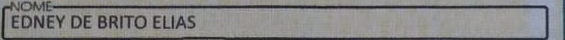

In [ ]:
# extraindo o nome com base nas coordenadas do ponto de referência
img_nome = img[y-50:y-10,x-10:img.shape[1]-80]
cv2_imshow(img_nome)

Com a região que contém o nome selecionada, é possível aplicar OCR e retirar o nome do portador da CNH.

In [ ]:
# Salvando a imagem que contém o nome...o Tesseract lê o arquivo da imagem não um nparray
cv2.imwrite("/content/CNH_teste_nome.jpeg", img_nome)
nome = pytesseract.image_to_string(Image.open("/content/CNH_teste_nome.jpeg"))
print(nome)

Omi
[ EDNEY DE BRITO ELIAS |



O OCR encontrou alguns ruídos, portanto é preciso separar o nome detro dessa string.

In [ ]:
# O nome está na segunda linha
linhaNome = nome.split("\n")[1]
listNome=[]
# Itera por todos os caracteres da segunda linha e identifica as letras e os espaços dos demais caracteres
for palavra in linhaNome:
  if palavra.isalpha() or palavra.isspace():
    listNome.append(palavra)
dadoNome = ""
for letra in listNome:
  dadoNome += letra
print(dadoNome)

 EDNEY DE BRITO ELIAS 


Os dados estão ao lado da foto do portador da CNH. Depois de indentificada a região o mesmo processo é aplicado para extrair os dados.

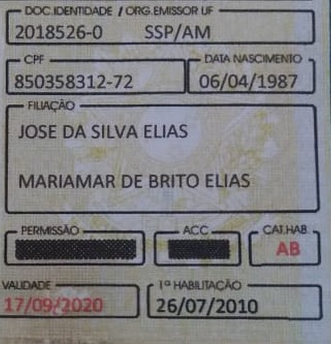

In [ ]:
# extraindo os dados com base nas coordenadas do ponto de referência
img_dados = img[y-10:,x+w+10:img.shape[1]-80]
cv2_imshow(img_dados)

In [ ]:
cv2.imwrite("/content/CNH_teste_dados.jpeg", img_dados)
dados = pytesseract.image_to_string(Image.open("/content/CNH_teste_dados.jpeg"))
print(dados)

DOCIDENTIDADE 1 ORG EMISSOR UF _
2018526-0 SSP/AM.

cr DATA NASCIMENTO
850358312-72 | 06/04/1987

FRAGA
JOSE DA SILVA ELIAS

MARIAMAR DE BRITO ELIAS

PERMISSAD ALC. (CALHAB
ft] |
irene} { 26/07/2010 }
7

 



# Resultado

In [ ]:
dados_por_linha = dados.split("\n")
# RG é a primeira informação da linha 1
dadoRG = dados_por_linha[1].split(" ")[0]
# CPF é a primeira informação da linha 4
dadoCPF = dados_por_linha[4].split(" ")[0]
# Mostrando os resultados
print(f"Nome da CNH {dadoNome}\nRG da CNH {dadoRG}\nCPF da CNH {dadoCPF}")

Nome da CNH  EDNEY DE BRITO ELIAS 
RG da CNH 2018526-0
CPF da CNH 850358312-72


# Conclusão

Apesar do sucesso em extrair os dados do portandor da CNH, utlizando somente PDI, acredito que essa estratégia possui pouca robustez. O teste abaixo com uma outra imagem ilustra bem esse fato.



352 540


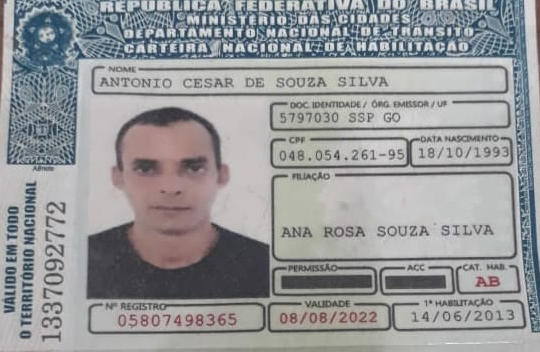

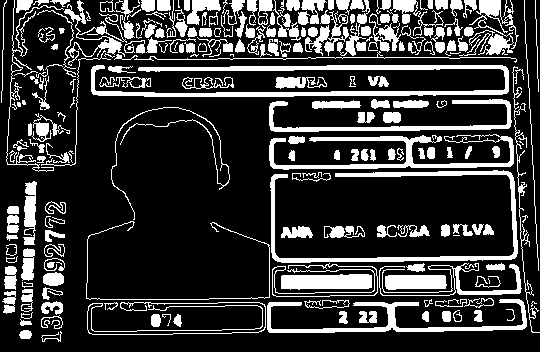

In [ ]:
img_teste = cv2.imread("/content/28-CNH-falsa-em-Amambai.jpg")
print(img_teste.shape[0], img_teste.shape[1])

img_gray_teste = cv2.cvtColor(img_teste, cv2.COLOR_RGB2GRAY)
img_blur_teste = cv2.GaussianBlur(img_gray_teste, (5,5), 0)
img_canny_teste = cv2.Canny(img_blur_teste, 70, 220)

cv2_imshow(img_teste)

h_teste, w_teste = img_teste.shape[:2]
mask_teste = np.zeros((h_teste+2, w_teste+2), np.uint8)
img_floodFill_teste = img_canny_teste.copy()
cv2.floodFill(img_floodFill_teste, mask_teste, (0,0), 255)
img_floodFill_inv_teste = cv2.bitwise_not(img_floodFill_teste)
img_processada_teste = img_canny_teste | img_floodFill_inv_teste
cv2_imshow(img_processada_teste)

Como é possível observar, utlizando os mesmos parâmetros de processamento da primeira imagem neste segunda exemplo não é possível extrair a localização da foto do portador da CNH. Com esse informação faltante também não é possível indetificar o nome, CPF e RG. Este [artigo](https://medium.com/senior/deep-learning-e-ocr-reconhecimento-de-documentos-76c580ca93b1) mostra uma solução utilizando o AWS, que parece promissora.